## analytics 

In [1]:
import os
import pandas as pd
from sqlalchemy import create_engine, text
from dotenv import load_dotenv

# -------- 1. LOAD ENV VARIABLES --------
load_dotenv()   # This loads the .env file

DB_USER = os.getenv("DB_USER")
DB_PASSWORD = os.getenv("DB_PASSWORD")
DB_HOST = os.getenv("DB_HOST")
DB_PORT = os.getenv("DB_PORT")
DB_NAME = os.getenv("DB_NAME")

# -------- 2. CREATE ENGINE SAFELY --------
engine = create_engine(
    f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
)

# -------- 3. TEST CONNECTION --------
with engine.connect() as conn:
    result = conn.execute(text("SELECT 1;")).fetchall()
    print("✅ DB connection OK:", result)

# -------- 4. LOAD SAMPLE FROM dispatch_region_5min --------
query = """
    SELECT *
    FROM dispatch_region_5min
    ORDER BY settlement_ts
    LIMIT 10;
"""

df_sample = pd.read_sql(query, engine)

print("\n📊 Sample rows:")
print(df_sample)

print("\n📋 Columns:", df_sample.columns.tolist())


✅ DB connection OK: [(1,)]

📊 Sample rows:
        settlement_ts region_id  total_demand
0 2025-01-01 00:05:00      TAS1        989.78
1 2025-01-01 00:05:00      NSW1       7251.07
2 2025-01-01 00:05:00      VIC1       4339.00
3 2025-01-01 00:05:00      QLD1       6444.99
4 2025-01-01 00:05:00       SA1       1379.47
5 2025-01-01 00:10:00      QLD1       6469.55
6 2025-01-01 00:10:00      VIC1       4310.79
7 2025-01-01 00:10:00      TAS1        991.04
8 2025-01-01 00:10:00       SA1       1367.61
9 2025-01-01 00:10:00      NSW1       7297.85

📋 Columns: ['settlement_ts', 'region_id', 'total_demand']


In [2]:
df = df_sample = None  # reset if needed

import pandas as pd

df = pd.read_sql("""
    SELECT *
    FROM dispatch_region_5min
    ORDER BY settlement_ts;
""", engine)

df["settlement_ts"] = pd.to_datetime(df["settlement_ts"])
df["date"] = df["settlement_ts"].dt.date

df.head()


,settlement_ts,region_id,total_demand,date
0,2025-01-01 00:05:00,TAS1,989.78,2025-01-01
1,2025-01-01 00:05:00,NSW1,7251.07,2025-01-01
2,2025-01-01 00:05:00,SA1,1379.47,2025-01-01
3,2025-01-01 00:05:00,QLD1,6444.99,2025-01-01
4,2025-01-01 00:05:00,VIC1,4339.00,2025-01-01


In [3]:
daily_group = df.groupby(["date", "region_id"])

df_daily = daily_group["total_demand"].agg(
    avg_5min_demand="mean",
    daily_peak="max",
    daily_min="min",
    total_demand_sum="sum"
).reset_index()

# Convert MW to MWh (5-minute intervals → 5/60 hours)
df_daily["total_daily_energy_mwh"] = df_daily["total_demand_sum"] * (5.0 / 60.0)

df_daily = df_daily.drop(columns=["total_demand_sum"])

df_daily.head()


,date,region_id,avg_5min_demand,daily_peak,daily_min,total_daily_energy_mwh
0,2025-01-01,NSW1,6774.125714,9434.59,4534.57,162014.506667
1,2025-01-01,QLD1,6039.234634,7808.79,4554.92,144438.361667
2,2025-01-01,SA1,862.286655,1518.36,10.55,20623.022500
3,2025-01-01,TAS1,999.820767,1104.47,920.09,23912.380000
4,2025-01-01,VIC1,3293.134390,4488.60,1400.13,78760.797500


In [4]:
# Create new table
df_daily.to_sql(
    "daily_usage",
    engine,
    index=False,
    if_exists="replace"
)

print("✅ daily_usage table created:", len(df_daily), "rows")

✅ daily_usage table created: 1520 rows


### Daily_Usage


### STEP 1 — Load daily_usage from Postgres

In [5]:
df_daily = pd.read_sql("SELECT * FROM daily_usage ORDER BY date, region_id;", engine)
df_daily.head()


,date,region_id,avg_5min_demand,daily_peak,daily_min,total_daily_energy_mwh
0,2025-01-01,NSW1,6774.125714,9434.59,4534.57,162014.506667
1,2025-01-01,QLD1,6039.234634,7808.79,4554.92,144438.361667
2,2025-01-01,SA1,862.286655,1518.36,10.55,20623.022500
3,2025-01-01,TAS1,999.820767,1104.47,920.09,23912.380000
4,2025-01-01,VIC1,3293.134390,4488.60,1400.13,78760.797500


In [7]:
df_daily[[
    "region_id",
    "avg_5min_demand",
    "daily_peak",
    "daily_min",
    "total_daily_energy_mwh"
]].isnull().sum()


region_id                 0
avg_5min_demand           0
daily_peak                0
daily_min                 0
total_daily_energy_mwh    0
dtype: int64

In [8]:
df_daily[[
    "avg_5min_demand",
    "daily_peak",
    "daily_min",
    "total_daily_energy_mwh"
]].describe()


,avg_5min_demand,daily_peak,daily_min,total_daily_energy_mwh
count,1520.000000,1520.000000,1520.000000,1520.000000
mean,4252.187767,5557.516033,3080.979895,102040.767012
std,2680.629204,3471.609525,2144.964888,64327.278790
min,862.286655,1020.300000,-185.490000,20623.022500
25%,1233.106007,1694.282500,914.872500,29594.544167
50%,4914.990226,6563.050000,3371.510000,117959.765417
75%,6400.622726,8289.065000,4748.412500,153614.945417
max,10300.944599,13159.460000,7863.450000,246364.258333


### STEP 5 — Summary stats per region

In [9]:
df_daily.groupby("region_id")[[
    "avg_5min_demand",
    "daily_peak",
    "daily_min",
    "total_daily_energy_mwh"
]].describe()


avg_5min_demand                                                     \
                    count         mean         std          min          25%   
region_id                                                                      
NSW1                304.0  7624.271100  971.514669  5485.598229  6868.066398   
QLD1                304.0  6184.749264  514.207019  5049.669688  5840.555252   
SA1                 304.0  1372.545865  244.803401   862.286655  1193.815387   
TAS1                304.0  1073.855509   93.989924   885.367882  1004.026649   
VIC1                304.0  5005.517097  752.928868  3293.134390  4414.057778   

                                                  daily_peak               \
                   50%          75%           max      count         mean   
region_id                                                                   
NSW1       7506.241337  8377.062465  10300.944599      304.0  9818.330954   
QLD1       6135.666111  6522.260260   8144.965451      304.0  8073.497434   
SA1        1345.939201  1561.823802   2215.265035      304.0  1954.059901   
TAS1       1063.231649  1133.686102   1345.858467      304.0  1272.321480   
VIC1       4914.990226  5581.237240   6738.374375      304.0  6669.370395   

           ...  daily_min          total_daily_energy_mwh                 \
           ...        75%      max                  count           mean   
region_id  ...                                                             
NSW1       ...  6515.5850  7863.45                  304.0  182961.105269   
QLD1       ...  5310.1850  6655.30                  304.0  148416.822327   
SA1        ...   913.9750  1733.96                  304.0   32937.406124   
TAS1       ...   973.1275  1138.55                  304.0   25769.480762   
VIC1       ...  4196.0300  4948.39                  304.0  120119.020578   

                                                                      \
                    std            min            25%            50%   
region_id                                                              
NSW1       23308.640639  131654.357500  164833.593542  180149.792083   
QLD1       12338.103130  121192.072500  140173.326042  147255.986667   
SA1         5875.064973   20623.022500   28576.879792   32302.540833   
TAS1        2254.104873   21248.829167   24058.077708   25517.559583   
VIC1       18069.558721   78760.797500  105937.386667  117959.765417   

                                         
                     75%            max  
region_id                                
NSW1       201049.499167  246364.258333  
QLD1       156534.246250  195479.170833  
SA1         37483.771250   53166.360833  
TAS1        27208.466458   32188.448333  
VIC1       133949.693750  161720.985000  

[5 rows x 32 columns]

In [10]:
df_daily.groupby("region_id")["date"].count()


region_id
NSW1    304
QLD1    304
SA1     304
TAS1    304
VIC1    304
Name: date, dtype: int64

In [11]:
df_daily.duplicated().sum()


0

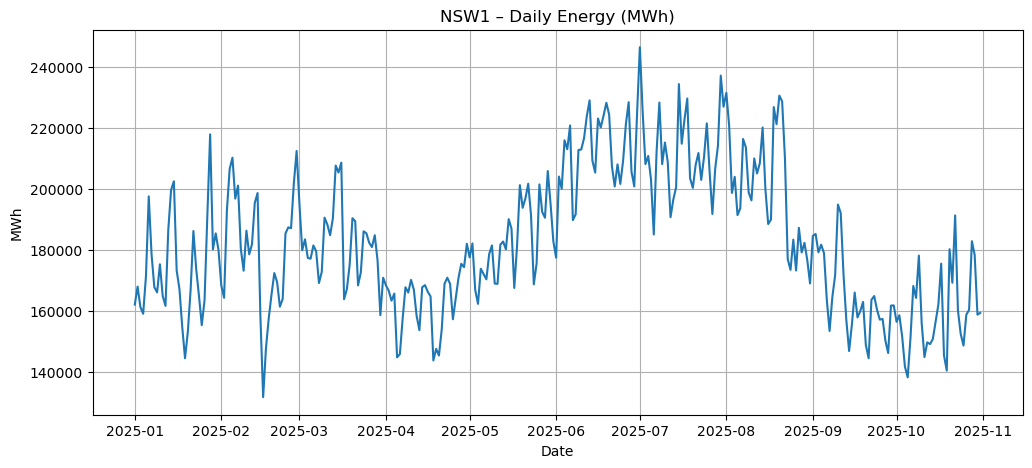

In [12]:
import matplotlib.pyplot as plt

nsw = df_daily[df_daily["region_id"] == "NSW1"]

plt.figure(figsize=(12,5))
plt.plot(nsw["date"], nsw["total_daily_energy_mwh"])
plt.title("NSW1 – Daily Energy (MWh)")
plt.xlabel("Date")
plt.ylabel("MWh")
plt.grid()
plt.show()



### STEP 9 — Compare average demand across regions

In [13]:
df_daily.groupby("region_id")["avg_5min_demand"].mean().sort_values(ascending=False)


region_id
NSW1    7624.271100
QLD1    6184.749264
VIC1    5005.517097
SA1     1372.545865
TAS1    1073.855509
Name: avg_5min_demand, dtype: float64

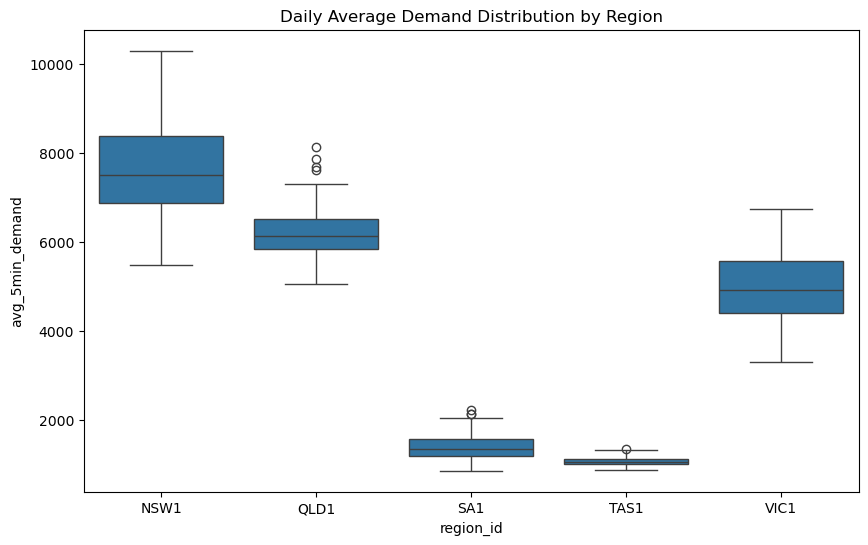

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))
sns.boxplot(data=df_daily, x="region_id", y="avg_5min_demand")
plt.title("Daily Average Demand Distribution by Region")
plt.show()


### STEP 11 — Peak Days (top 5 per region)

In [15]:

peak_days = (
    df_daily.sort_values("daily_peak", ascending=False)
             .groupby("region_id")
             .head(5)
)

peak_days


,date,region_id,avg_5min_demand,daily_peak,daily_min,total_daily_energy_mwh
905,2025-07-01,NSW1,10300.944599,13159.46,7406.16,246364.258333
1145,2025-08-18,NSW1,9447.401771,12729.23,7226.72,226737.642500
1050,2025-07-30,NSW1,9877.661944,12670.35,7308.58,237063.886667
830,2025-06-16,NSW1,9291.643507,12342.50,7272.73,222999.444167
975,2025-07-15,NSW1,9761.569618,12339.33,7442.96,234277.670833
106,2025-01-22,QLD1,7873.107604,11159.32,6257.16,188954.582500
116,2025-01-24,QLD1,8144.965451,10896.53,6655.30,195479.170833
1496,2025-10-27,QLD1,7117.590347,10167.64,5344.78,170822.168333
76,2025-01-16,QLD1,7616.726736,10041.18,6352.73,182801.441667
71,2025-01-15,QLD1,7254.419549,10027.09,5763.34,174106.069167


### STEP 12 — Lowest Demand Days (renewable-heavy)

In [16]:
low_days = (
    df_daily.sort_values("daily_min", ascending=True)
             .groupby("region_id")
             .head(5)
)

low_days

,date,region_id,avg_5min_demand,daily_peak,daily_min,total_daily_energy_mwh
1422,2025-10-12,SA1,901.998403,1531.40,-185.49,21647.961667
1502,2025-10-28,SA1,896.187049,1536.97,-112.58,21508.489167
1507,2025-10-29,SA1,910.473854,1528.36,-112.44,21851.372500
1452,2025-10-18,SA1,875.954306,1478.26,-112.30,21022.903333
232,2025-02-16,SA1,936.085799,1482.28,-110.47,22466.059167
38,2025-01-08,TAS1,913.430451,1070.85,692.39,21922.330833
1483,2025-10-24,TAS1,913.201771,1128.12,715.88,21916.842500
1463,2025-10-20,TAS1,894.509201,1085.13,731.79,21468.220833
48,2025-01-10,TAS1,955.399167,1123.84,735.26,22929.580000
1268,2025-09-11,TAS1,1002.155556,1195.77,736.33,24051.733333


In [17]:
df_daily[[
    "avg_5min_demand",
    "daily_peak",
    "daily_min",
    "total_daily_energy_mwh"
]].corr()


,avg_5min_demand,daily_peak,daily_min,total_daily_energy_mwh
avg_5min_demand,1.000000,0.994937,0.979749,0.999999
daily_peak,0.994937,1.000000,0.962247,0.994935
daily_min,0.979749,0.962247,1.000000,0.979751
total_daily_energy_mwh,0.999999,0.994935,0.979751,1.000000


### STEP 14 — Weekday Analysis (behavior patterns)

In [18]:
df_daily["date"] = pd.to_datetime(df_daily["date"])
df_daily["weekday"] = df_daily["date"].dt.day_name()

df_daily.groupby(["region_id", "weekday"])["avg_5min_demand"].mean().unstack()

weekday,Friday,Monday,Saturday,Sunday,Thursday,Tuesday,Wednesday
region_id,,,,,,,
NSW1,7800.334673,7695.016770,7231.229673,7096.628513,7876.633876,7829.703024,7825.703300
QLD1,6295.749215,6255.765066,5958.842811,5838.082923,6298.718324,6315.883089,6321.784709
SA1,1370.193820,1435.557623,1326.169305,1280.553232,1382.538317,1417.552526,1394.566442
TAS1,1077.252729,1087.424633,1054.951079,1051.814328,1088.723123,1085.680717,1070.788518
VIC1,5127.229744,5062.295233,4676.188405,4619.155481,5189.544127,5184.024307,5169.264084


### STEP 15 — Heatmap (weekday × region)

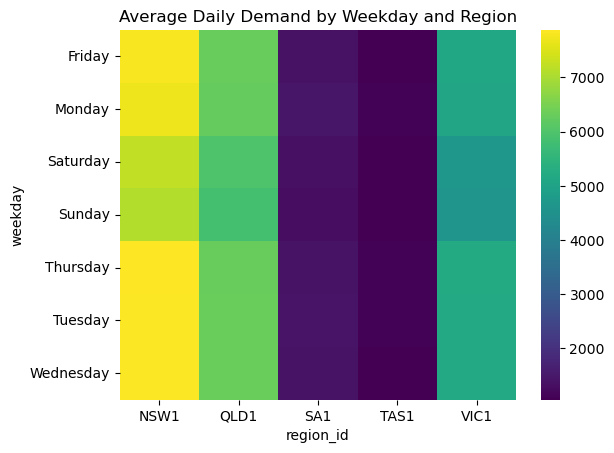

In [19]:
pivot = df_daily.pivot_table(
    index="weekday", 
    columns="region_id",
    values="avg_5min_demand",
    aggfunc="mean"
)

sns.heatmap(pivot, annot=False, cmap="viridis")
plt.title("Average Daily Demand by Weekday and Region")
plt.show()
